In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

# Wczytywanie danych

### Ceny

Ceny z https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce.
Okres: 2024-02-20 - 2024-03-21, krok - 1 godzina.

In [2]:
prices = pd.read_csv("data\\prices\\ceny_lipiec.csv", delimiter=';', decimal=',')

In [3]:
prices.Godzina = prices.Godzina - 1  # dodawać 1 dzień do daty
prices['dt'] = prices.Data * 100 + prices.Godzina
prices.dt = pd.to_datetime(prices.dt, format='%Y%m%d%H')
prices = prices.drop(columns=['Data', 'Godzina'])
prices.RCE = prices.RCE / 1000

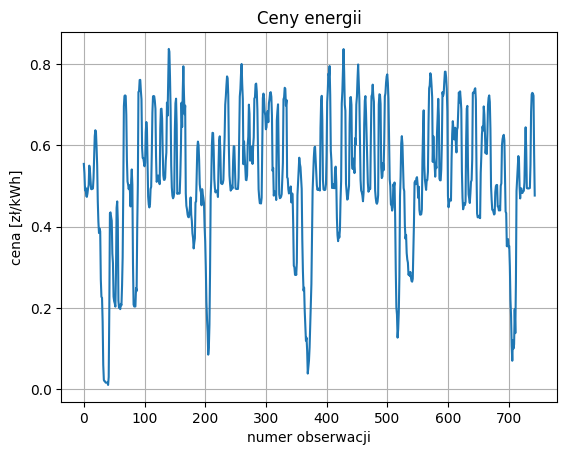

In [4]:
_ = prices.RCE.plot(grid=True, xlabel='numer obserwacji', ylabel='cena [zł/kWh]', title='Ceny energii')

### Energia

Dane z solcast.com dla Wrocławia. Okres: 2024-02-20 - 2024-03-21, krok - 1 godzina.

GHI - całkowite natężenie promieniowania słonecznego na poziomej powierzchni Ziemi. Jest to suma bezpośredniego napromieniowania (po uwzględnieniu kąta zenitalnego Słońca z) i rozproszonego poziomego napromieniowania

In [5]:
ghi = pd.read_csv('data\\solar_stuff\\solar_short.csv', usecols=['ghi', 'period_end'])
ghi.period_end = pd.to_datetime(ghi.period_end)

In [6]:
ghi = ghi[(ghi.period_end >= "2023-07-01") & (ghi.period_end <= "2023-07-31")]
ghi = ghi.reset_index()
ghi.ghi = ghi.ghi / 1000

In [7]:
ghi

,index,ghi,period_end
0,4343,0.000,2023-07-01 00:00:00+00:00
1,4344,0.000,2023-07-01 01:00:00+00:00
2,4345,0.000,2023-07-01 02:00:00+00:00
3,4346,0.001,2023-07-01 03:00:00+00:00
4,4347,0.025,2023-07-01 04:00:00+00:00
...,...,...,...
716,5059,0.000,2023-07-30 20:00:00+00:00
717,5060,0.000,2023-07-30 21:00:00+00:00
718,5061,0.000,2023-07-30 22:00:00+00:00
719,5062,0.000,2023-07-30 23:00:00+00:00


# Dobór funkcji

In [8]:
test_date = '2023-07-14'

### Ceny

In [9]:
prices_train = prices[prices.dt < test_date]

In [10]:
def _price_func(x, a, b, c, d, e, f, g):
    return a * np.sin(b * (2 * np.pi) * x + c) + \
        d * np.sin(2 * np.pi * e * x + f) + g

In [11]:
price_params = scipy.optimize.curve_fit(_price_func, prices_train.index, prices_train.RCE,
                                        p0=[prices_train.std().iloc[0],
                                            1 / (7 * 24),
                                            1,
                                            prices_train.std().iloc[0],
                                            1 / 24,
                                            1,
                                            prices_train.mean().iloc[0]])

In [12]:
price_params[0]

array([-0.14054548,  0.00649954, -0.30069391,  0.10091864,  0.04222861,
        1.8244978 ,  0.51070261])

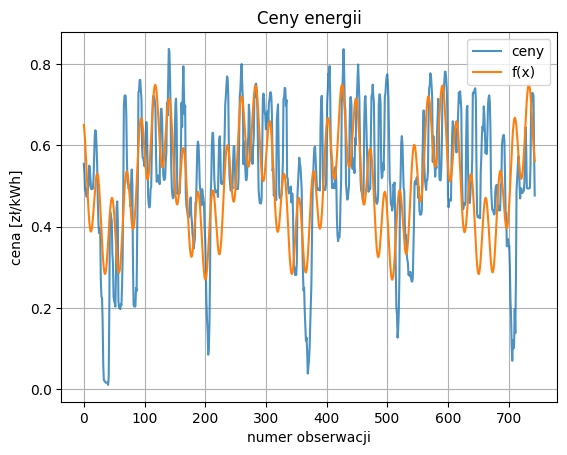

In [13]:
_ = prices.RCE.plot(grid=True, xlabel='numer obserwacji', ylabel='cena [zł/kWh]', title='Ceny energii', alpha=0.8)
_ = plt.plot(prices.index, _price_func(prices.index, *price_params[0]), c='C1', alpha=1)
_ = plt.legend(['ceny', 'f(x)'])

In [14]:
print('{}sin(2pi{}x + {}) + {}sin(2pi{}x + {}) + {}'.
      format(*[np.round(param, 3) for param in price_params[0]]))

-0.141sin(2pi0.006x + -0.301) + 0.101sin(2pi0.042x + 1.824) + 0.511


In [15]:
price_func = lambda x: _price_func(x, *price_params[0])

### Energia

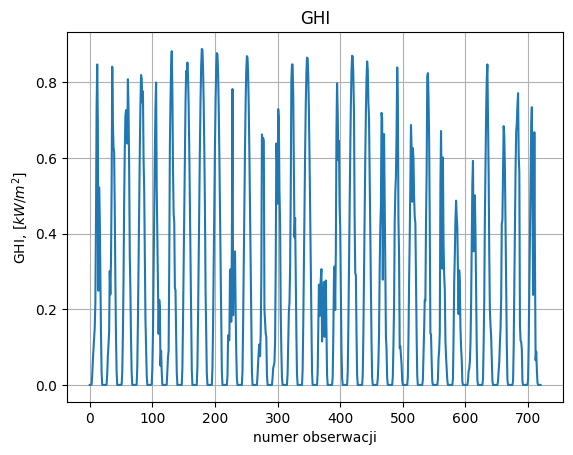

In [16]:
_ = ghi.ghi.plot(title="GHI", grid=True, xlabel="numer obserwacji", ylabel="GHI, [$kW/m^2$]")

In [17]:
area = 1 * 1.65
efficiency = 1
ghi["energy"] = ghi.ghi * area * efficiency

In [18]:
def _energy_func(x, a, b, c):
    temp = a * np.sin(2 * np.pi * b * x + c)
    return [t if t > 0 else 0 for t in temp]

In [19]:
energy_params = scipy.optimize.curve_fit(_energy_func, ghi.index, ghi.energy,
                                         p0=[ghi.energy.std(),
                                             1 / 24,
                                             1])

In [20]:
energy_params[0]

array([ 1.14844951,  0.04169158, -1.48736616])

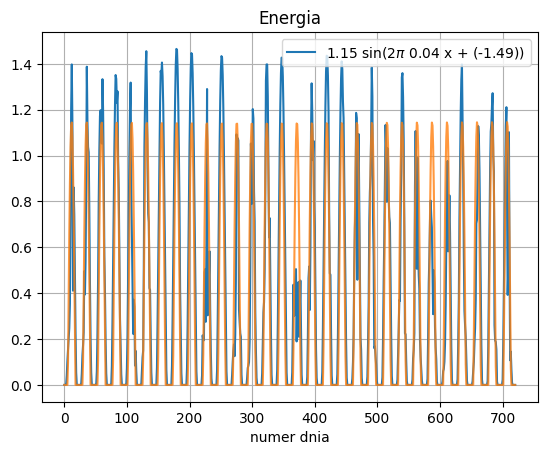

In [21]:
_ = ghi.energy.plot(title="Energia", xlabel="numer dnia", grid=True)
_ = plt.plot(ghi.index, _energy_func(ghi.index, *energy_params[0]), c='C1', alpha=0.8)
_ = plt.legend(['{} sin(2$\pi$ {} x + ({}))'.
               format(*[np.round(param, 2) for param in energy_params[0]])])

In [22]:
energy_func = lambda x: _energy_func(x, *energy_params[0])

### Zapotrzebowanie

In [33]:
from demand import demand, step_demand

# Ograniczenia

In [24]:
annual_demand = 0  #[MWh]

In [25]:
Rc = 20  # the energy capacity in kWh
nc = 0.8  # the charging efficiency of the device
nd = 0.8  # the discharging efficiency of the device
gc = Rc / 5  # the max charging rate of the device [MWh per hour]
gd = Rc / 5  # the max discharging rate of the device [MWh per hour]
ch = 1  # the holding cost of the device [$ per MWh per time step]

In [26]:
Rc

20

# Zmienne i stan

In [27]:
dates = prices[prices.dt >= test_date].dt.reset_index(drop=True)
t = np.arange(len(dates))

S = pd.DataFrame({"P": price_func(t),
                  "D": demand(t, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})

phi = np.array([0, 0, -1, nc, nc, -1])

In [28]:
S.E = 10 * S.E

# Rozwiązanie

In [29]:
from solver import solve

### Zerowe zapotrzebowanie roczne

In [576]:
xs = solve(S, Rc, nc, nd, gc, gd)

In [577]:
S.R = xs.cumsum().dot(phi)

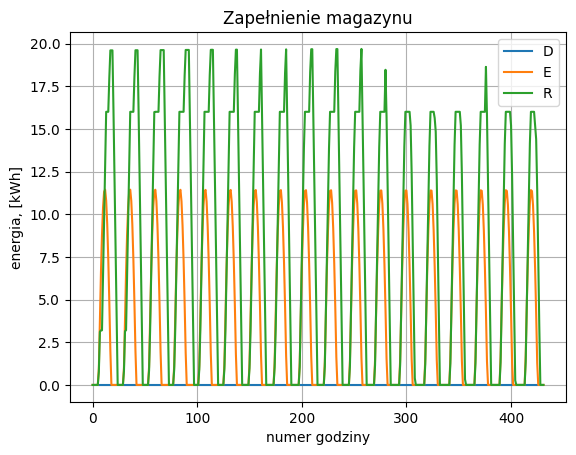

In [578]:
_ = S[["D", "E", "R"]].plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]",
                            title = 'Zapełnienie magazynu')

### Stałe niezerowe zapotrzebowanie roczne

In [583]:
annual_demand = 50 * 10 ** 3
S_constant = S = pd.DataFrame({"P": price_func(t),
                  "D": demand(t, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})
S.E = 10 * S.E

In [584]:
xs_constant_demand = solve(S_constant, Rc, nc, nd, gc, gd)

In [585]:
S_constant.R = xs_constant_demand.dot(phi).cumsum()

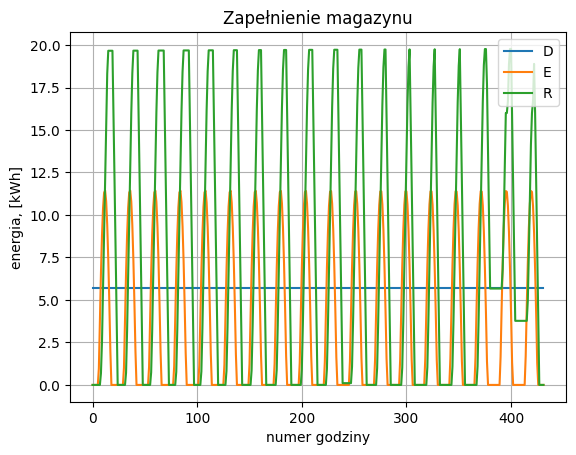

In [589]:
_ = S_constant.drop(columns=["P"]).plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]",
                            title = 'Zapełnienie magazynu')

### Zapotrzebowanie - funkcja schodkowa

In [34]:
annual_demand = 50 * 10 ** 3
S_step = pd.DataFrame({"P": price_func(t),
                  "D": step_demand(t, dates, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})
S_step.E = 10 * S_step.E

<Axes: >

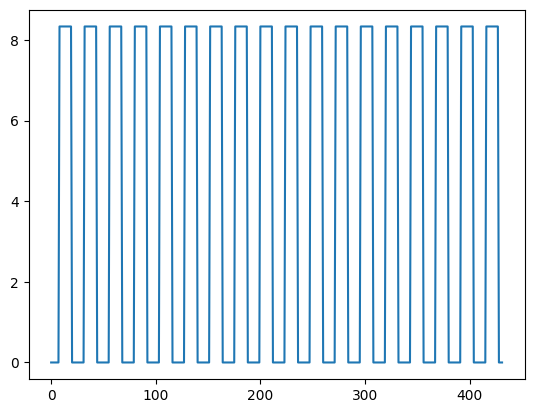

In [35]:
_ = S_step.D.plot()

In [591]:
xs_step_demand = solve(S_step, Rc, nc, nd, gc, gd)

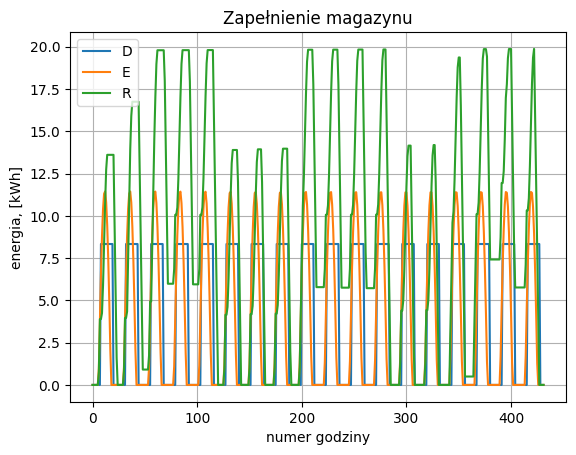

In [592]:
S_step.R = xs_step_demand.dot(phi).cumsum()
_ = S_step[["D", "E", "R"]].plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]",
                            title = 'Zapełnienie magazynu')

In [37]:
dates

0     2023-07-14 00:00:00
1     2023-07-14 01:00:00
2     2023-07-14 02:00:00
3     2023-07-14 03:00:00
4     2023-07-14 04:00:00
              ...        
427   2023-07-31 19:00:00
428   2023-07-31 20:00:00
429   2023-07-31 21:00:00
430   2023-07-31 22:00:00
431   2023-07-31 23:00:00
Name: dt, Length: 432, dtype: datetime64[ns]